In [223]:
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
from tqdm import tqdm

In [224]:
import random
import math

In [225]:
from enum import Enum

In [226]:
from PIL import Image, ImageDraw
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

#### Functions for drawing a square / circle / triangle on a given image - using ImageDraw module
<https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html>

In [227]:
def draw_square(image, x, y, square_size, color):
    draw = ImageDraw.Draw(image)
    draw.rectangle([(x,y), (x+square_size,y+square_size)], fill = color, outline = color)

def draw_circle(image, x, y, circle_size, color):
    draw = ImageDraw.Draw(image)
    draw.ellipse([(x,y), (x+circle_size,y+circle_size)], fill = color, outline = color)

def draw_triangle(image, vertices, color):
    draw = ImageDraw.Draw(image)
    draw.polygon(vertices, fill = color, outline = color)

#### Figure class hierarchy  
Implemented based on the information needed to draw each figure.  
Individual is represented as a list of figures of a certain type.  
Since figure represents one gene, classes also have mutation methods. 

In [228]:
class Figure:

    COL_MUTATION_LMT = 35
    POS_MUTATION_LMT = 50
    SIZE_MUTATION_LMT = 10
    TRANSP_MUTATION_LMT = 0.2
    MIN_SIZE = 2
    
    def __init__(self, color: (int, int, int)):
        self.color = color

    def mutate_color(self):
        rnd_r = random.randrange((-1) * Figure.COL_MUTATION_LMT, Figure.COL_MUTATION_LMT)
        rnd_g = random.randrange((-1) * Figure.COL_MUTATION_LMT, Figure.COL_MUTATION_LMT)
        rnd_b = random.randrange((-1) * Figure.COL_MUTATION_LMT, Figure.COL_MUTATION_LMT)
        rnd_a = random.uniform((-1) * Figure.TRANSP_MUTATION_LMT, Figure.TRANSP_MUTATION_LMT)
        
        new_r = self.color[0] + rnd_r
        new_g = self.color[1] + rnd_g
        new_b = self.color[2] + rnd_b
        new_a = self.color[3] + rnd_a

        # making sure that new values are valid RGB values in [0, 255], and transparency is in (0.1,1]
        if (new_r in range(0, 256)) and (new_g in range(0, 256)) and (new_b in range(0, 256)) and new_a > 0.1 and new_a <= 1.0:
            self.color = (new_r, new_g, new_b, new_a)

    def mutate_position(self, img_width, img_height):
        pass

    def mutate_size(self, img_width, img_height):
        pass

    def mutate_whole(self, img_width, img_height):
        self.mutate_color()
        self.mutate_position(img_width, img_height)
        self.mutate_size(img_width, img_height)

In [229]:
class Square(Figure):
    
    def __init__(self, color: (int, int, int), x: int, y: int, size: int):
        Figure.__init__(self, color)
        self.position = (x,y) # top left square vertix coords
        self.size = size

    def mutate_position(self, img_width, img_height):
        on_x = random.randrange((-1) * Figure.POS_MUTATION_LMT, Figure.POS_MUTATION_LMT)
        on_y = random.randrange((-1) * Figure.POS_MUTATION_LMT, Figure.POS_MUTATION_LMT)
        new_x = self.position[0] + on_x
        new_y = self.position[1] + on_y

        # making sure that figure doesn't go out of picture
        if new_x >= 0 and new_x <= img_width - self.size and new_y >= 0 and new_y <= img_height - self.size:
            self.position = (new_x, new_y)

    def mutate_size(self, img_width, img_height):
        rnd_fact = random.choice(list(set(range((-1) * Figure.SIZE_MUTATION_LMT, Figure.SIZE_MUTATION_LMT)).difference({0})))
        new_size = self.size + rnd_fact

        # making sure that figure doesn't go out of picture
        if new_size > Figure.MIN_SIZE and self.position[0] + new_size <= img_width and self.position[1] + new_size <= img_height:
            self.size = new_size

In [230]:
class Circle(Figure):
    
    def __init__(self, color: (int, int, int), x: int, y: int, size: int):
        Figure.__init__(self, color)
        self.position = (x,y) # top left bounding box vertix coords
        self.size = size

    def mutate_position(self, img_width, img_height):
        on_x = random.randrange((-1) * Figure.POS_MUTATION_LMT, Figure.POS_MUTATION_LMT)
        on_y = random.randrange((-1) * Figure.POS_MUTATION_LMT, Figure.POS_MUTATION_LMT)
        new_x = self.position[0] + on_x
        new_y = self.position[1] + on_y

        # making sure that figure doesn't go out of picture
        if new_x >= 0 and new_x <= img_width - self.size and new_y >= 0 and new_y <= img_height - self.size:
            self.position = (new_x, new_y)

    def mutate_size(self, img_width, img_height):
        rnd_fact = random.choice(list(set(range((-1) * Figure.SIZE_MUTATION_LMT, Figure.SIZE_MUTATION_LMT)).difference({0})))
        new_size = self.size + rnd_fact

        # making sure that figure doesn't go out of picture
        if new_size > Figure.MIN_SIZE and self.position[0] + new_size <= img_width and self.position[1] + new_size <= img_height:
            self.size = new_size

In [231]:
class Triangle(Figure):

    SCALE_LMT = 1.1

    def __init__(self, color: (int, int, int), vertices: [(float, float)]):
        Figure.__init__(self, color)
        self.vertices = deepcopy(vertices)
        self.centre = (sum([self.vertices[i][0] for i in range(0, 3)])/3, sum([self.vertices[i][1] for i in range(0, 3)])/3)

    def mutate_position(self, img_width, img_height):
        # triangle is defined by its vertices, mutation here means translation by vector (on_x, on_y):
        # adding the same on_x factor to each vertix' x coord & the same on_y factor to each vertix' y coord
        on_x = random.uniform((-1) * Figure.POS_MUTATION_LMT, Figure.POS_MUTATION_LMT)
        on_y = random.uniform((-1) * Figure.POS_MUTATION_LMT, Figure.POS_MUTATION_LMT)

        new_vertices = [(self.vertices[i][0] + on_x, self.vertices[i][1] + on_y) for i in range(0, 3)]

        if all([new_vertices[i][0] >= 0 and new_vertices[i][0] <= img_width and new_vertices[i][1] >= 0 and new_vertices[i][1] <= img_height
            for i in range(0, 3)]):
            self.vertices = deepcopy(new_vertices)

    def mutate_size(self, img_width, img_height):
        # translate centre to coord system origin
        new_vertices = [(self.vertices[i][0] - self.centre[0], self.vertices[i][1] - self.centre[1]) for i in range(0, 3)]
        
        # scale uniformly by random small factor
        rnd_fact = random.uniform(0.9, Triangle.SCALE_LMT)
        new_vertices = [(rnd_fact * new_vertices[i][0], rnd_fact * new_vertices[i][1]) for i in range(0, 3)]

        # and translate back to original position
        new_vertices = [(new_vertices[i][0] + self.centre[0], new_vertices[i][1] + self.centre[1]) for i in range(0, 3)]

        if all([new_vertices[i][0] >= 0 and new_vertices[i][0] <= img_width and new_vertices[i][1] >= 0 and new_vertices[i][1] <= img_height
            for i in range(0, 3)]):
            self.vertices = deepcopy(new_vertices)

#### Functions for generating a list of random figures  
Used for initializing a single Individual.

In [232]:
def gen_squares(num, img_width, img_height):
    code = []
    for i in range(num):
        rnd_r = random.randrange(0, 256)
        rnd_g = random.randrange(0, 256)
        rnd_b = random.randrange(0, 256)
        rnd_a = random.uniform(0.1, 1.01)
        if rnd_a > 1.0:
            rnd_a = 1.0

        rnd_size = random.randrange(Figure.MIN_SIZE, math.ceil(max(img_width, img_height)/2))

        rnd_x = random.randrange(0, img_width - rnd_size)
        rnd_y = random.randrange(0, img_height - rnd_size)

        sq = Square(color=(rnd_r, rnd_g, rnd_b, rnd_a), x=rnd_x, y=rnd_y, size=rnd_size)
        code.append(sq)
        
    return code

def gen_circles(num, img_width, img_height):
    code = []
    for i in range(num):
        rnd_r = random.randrange(0, 256)
        rnd_g = random.randrange(0, 256)
        rnd_b = random.randrange(0, 256)
        rnd_a = random.uniform(0.1, 1.01)
        if rnd_a > 1.0:
            rnd_a = 1.0

        rnd_size = random.randrange(Figure.MIN_SIZE, math.ceil(max(img_width, img_height)/2))

        rnd_x = random.randrange(0, img_width - rnd_size)
        rnd_y = random.randrange(0, img_height - rnd_size)

        cc = Circle(color=(rnd_r, rnd_g, rnd_b, rnd_a), x=rnd_x, y=rnd_y, size=rnd_size)
        code.append(cc)
        
    return code

def gen_triangles(num, img_width, img_height):
    code = []
    for i in range(num):
        rnd_r = random.randrange(0, 256)
        rnd_g = random.randrange(0, 256)
        rnd_b = random.randrange(0, 256)
        rnd_a = random.uniform(0.1, 1.01)
        if rnd_a > 1.0:
            rnd_a = 1.0

        # first generate two random different points A and B
        A = (random.uniform(0, img_width), random.uniform(0, img_height))
        B = (random.uniform(0, img_width), random.uniform(0, img_height))
        while A == B:
            B = (random.uniform(0, img_width), random.uniform(0, img_height))

        # then generate the 3rd point as a random point so that A, B and C are non-collinear
        C = (random.uniform(0, img_width), random.uniform(0, img_height))
        m = (B[1] - A[1])/(B[0] - A[0])
        while C[1] - A[1] == m * (C[0] - A[0]):
            C = (random.uniform(0, img_width), random.uniform(0, img_height))
        
        tr = Triangle(color=(rnd_r, rnd_g, rnd_b, rnd_a), vertices=[A, B, C])
        code.append(tr)
        
    return code

#### Function for drawing a single Individual based on figure type

In [233]:
class FigType(Enum):
    SQUARE = 0
    CIRCLE = 1
    TRIANGLE = 2

Figures can be transparent and transparency is stored as color parameter. Drawing them consists of drawing them as fully visible (ignoring transparency), and blending the before image with the new image using the figure transparency as the blending parameter <i>alpha</i>.  
Function used here is the <b>blend</b> function from <https://pillow.readthedocs.io/en/stable/reference/Image.html>.  
Resulting image is: out = image1 * (1.0 - alpha) + image2 * alpha.

In [234]:
def draw_individual(individual, img, fig_type):
    if fig_type == FigType.SQUARE:
        for i in range(len(individual.code)):
            img_cp = img.copy()
            draw_square(image=img_cp,
                        x=individual.code[i].position[0],
                        y=individual.code[i].position[1],
                        square_size=individual.code[i].size,
                        color=(individual.code[i].color[0],individual.code[i].color[1],individual.code[i].color[2]))
            img = Image.blend(img, img_cp, individual.code[i].color[3]).copy()
    elif fig_type == FigType.CIRCLE:
        for i in range(len(individual.code)):
            img_cp = img.copy()
            draw_circle(image=img_cp,
                        x=individual.code[i].position[0],
                        y=individual.code[i].position[1],
                        circle_size=individual.code[i].size,
                        color=(individual.code[i].color[0],individual.code[i].color[1],individual.code[i].color[2]))
            img = Image.blend(img, img_cp, individual.code[i].color[3]).copy()
    elif fig_type == FigType.TRIANGLE:
        for i in range(len(individual.code)):
            img_cp = img.copy()
            draw_triangle(image=img_cp,
                          vertices=individual.code[i].vertices,
                          color=(individual.code[i].color[0],individual.code[i].color[1],individual.code[i].color[2]))
            img = Image.blend(img, img_cp, individual.code[i].color[3]).copy()
    return img

#### Individual class implementation  
Initialization is random.  
Fitness is calculated based on the difference between the original image and the image generated by Individual code (list of figures).  
Metric used here (after the initial try with MSE): SSIM from <https://scikit-image.org/docs/stable/api/skimage.metrics.html#>.  
Parameter values set according to:
- <https://scikit-image.org/docs/stable/api/skimage.metrics.html#re0d1cfbcf329-1>
- <https://ece.uwaterloo.ca/~z70wang/publications/ssim.pdf>

In [273]:
class Individual:

    def __init__(self, fig_type, num_figures, original_image):
        self.img_width = original_image.size[0]
        self.img_height = original_image.size[1]
        self.code = self.initialize(fig_type, num_figures, self.img_width, self.img_height)
        self.fitness = self.calc_fitness(fig_type, original_image)

    def initialize(self, fig_type, num_figures, img_width, img_height):
        if fig_type == FigType.SQUARE:
            return gen_squares(num_figures, img_width, img_height)
        elif fig_type == FigType.CIRCLE:
            return gen_circles(num_figures, img_width, img_height)
        elif fig_type == FigType.TRIANGLE:
            return gen_triangles(num_figures, img_width, img_height)

    def calc_fitness(self, fig_type, original_image):
        individual_img = Image.new("RGB", original_image.size, 'white')
        ind_img = draw_individual(self, individual_img, fig_type)
        
        ind_img_arr = np.array(ind_img)
        orig_img_arr = np.array(original_image)

        # larger the mse value, lower the fitness
        # fitness = (-1) * mean_squared_error(orig_img_arr, ind_img_arr)

        # fitness = peak_signal_noise_ratio(orig_img_arr, ind_img_arr)
        
        fitness = structural_similarity(
            orig_img_arr, ind_img_arr, channel_axis=2,
            data_range=ind_img_arr.max() - ind_img_arr.min(),
            gaussian_weights=True, sigma=1.5, use_sample_covariance=False,
            K1=0.01, K2=0.03
        )
        
        return fitness

#### Mutation  
Each gene mutates with a given probability.  
Mutation is implemented as a slight change in figure color, size and position.

In [236]:
def mutation(individual, mutation_prob=0.1):
    for i in range(len(individual.code)):
        if random.random() < mutation_prob:
            individual.code[i].mutate_whole(individual.img_width, individual.img_height)

#### Selection methods  
Both implemented so that second parent cannot be the same Individual as the first selected parent.

In [237]:
def tournament_selection(population, tournament_size, forbidden):
    allowed = list(set(range(len(population))).difference({forbidden}))
    competition = random.sample(allowed, tournament_size)

    chosen_idx = max(competition, key=lambda x: population[x].fitness)
    
    return chosen_idx

In [238]:
def roulette_selection(population, forbidden):
    allowed = list(set(range(len(population))).difference({forbidden}))

    sum_all_fitnesses = sum([population[i].fitness for i in allowed])
    probabilities = [population[i].fitness / sum_all_fitnesses for i in allowed]

    chosen_idx = random.choices(
        population=allowed,
        weights=probabilities,
        k=1
    )[0]

    return chosen_idx

In [239]:
class SelectType(Enum):
    TOURNAMENT = 0
    ROULETTE = 1

#### Crossover methods

##### K-point crossover  
Children inherit alternating parts from parents, after dividing parents' codes into k+1 parts.  
Individual code length depends on number of figures, so k is assumed to be in the correct range.

In [240]:
def k_point_crossover(parent1, parent2, child1, child2, k=1):
    positions = list(random.sample(list(range(1, len(parent1.code))), k))
    positions.sort()

    flag = True
    for i, pos in enumerate(positions):
        if i == 0:
            child1.code[:pos] = parent1.code[:pos]
            child2.code[:pos] = parent2.code[:pos]
            flag = False
        else:
            prev_pos = positions[i-1]
            if flag == True:
                child1.code[prev_pos:pos] = parent1.code[prev_pos:pos]
                child2.code[prev_pos:pos] = parent2.code[prev_pos:pos]
                flag = False
            else:
                child1.code[prev_pos:pos] = parent2.code[prev_pos:pos]
                child2.code[prev_pos:pos] = parent1.code[prev_pos:pos]
                flag = True
    pos = positions[i]
    if flag == True:
        child1.code[pos:] = parent1.code[pos:]
        child2.code[pos:] = parent2.code[pos:]
    else:
        child1.code[pos:] = parent2.code[pos:]
        child2.code[pos:] = parent1.code[pos:]

##### Uniform crossover  
A "coin toss" for each parent gene.

In [241]:
def uniform_crossover(parent1, parent2, child1, child2, prob=0.5):
    for i in range(len(parent1.code)):
        if random.random() < prob:
            child1.code[i] = parent1.code[i]
            child2.code[i] = parent2.code[i]
        else:
            child1.code[i] = parent2.code[i]
            child2.code[i] = parent1.code[i]

##### Mix crossover  
Up to a randomly selected position in code, child1 inherits parent1 genes and child2 inherits parent2 genes.  
Both children have the same mixed gene alleles on positions after the randomly selected position.  
Values are mixed for each figure characteristic.  
Mixing depends on given alpha value between 0 and 1 and new value is determined by:  
$newValue = alpha * parent1Value + (1 - alpha) * parent2Value$

In [242]:
def weighted_avg(val1, val2, alpha=0.5):
    return alpha * val1 + (1 - alpha) * val2

def mix_crossover(parent1, parent2, child1, child2, fig_type, alpha=0.5):
    
    pos = random.randrange(1, len(parent1.code))
    child1.code[:pos] = parent1.code[:pos]
    child2.code[:pos] = parent2.code[:pos]

    for i in range(pos, len(parent1.code)):
        mix_r = math.ceil(weighted_avg(parent1.code[i].color[0], parent2.code[i].color[0], alpha))
        mix_g = math.ceil(weighted_avg(parent1.code[i].color[1], parent2.code[i].color[1], alpha))
        mix_b = math.ceil(weighted_avg(parent1.code[i].color[2], parent2.code[i].color[2], alpha))
        mix_a = math.ceil(weighted_avg(parent1.code[i].color[3], parent2.code[i].color[3], alpha))
        
        child1.code[i].color = (mix_r, mix_g, mix_b, mix_a)
        child2.code[i].color = (mix_r, mix_g, mix_b, mix_a)
        
        if fig_type == FigType.SQUARE or fig_type == FigType.SQUARE:
            mix_size = math.ceil(weighted_avg(parent1.code[i].size, parent2.code[i].size, alpha))
            child1.code[i].size = mix_size
            child2.code[i].size = mix_size

            x = math.ceil(weighted_avg(parent1.code[i].position[0], parent2.code[i].position[0], alpha))
            y = math.ceil(weighted_avg(parent1.code[i].position[1], parent2.code[i].position[1], alpha))
            child1.code[i].position = (x,y)
            child2.code[i].position = (x,y)
        
        elif fig_type == FigType.TRIANGLE:
            for v in range(3):
                x = math.ceil(weighted_avg(parent1.code[i].vertices[v][0], parent2.code[i].vertices[v][0], alpha))
                y = math.ceil(weighted_avg(parent1.code[i].vertices[v][1], parent2.code[i].vertices[v][1], alpha))
                child1.code[i].vertices[v] = (x,y)
                child2.code[i].vertices[v] = (x,y)

In [243]:
class CrossType(Enum):
    KPOINT = 0
    UNIFORM = 1
    MIX = 2

#### GA for image reconstruction  
Returns the best Individual ever found that reconstructs given image with <code>num_figures</code> figures of a given figure type.

In [244]:
def ga_reconstruction(
    image,
    figure_type,
    num_figures: int,
    num_generations: int,
    population_size: int,
    use_elitism: bool = False,
    elitism_size: int = 0,
    mutation_prob: float = 0.1,
    crossover_type: str = CrossType.UNIFORM,
    crossover_param: float = None,
    selection_type: str = SelectType.ROULETTE,
    selection_param: int = None,
):
    if use_elitism and (population_size - elitism_size) % 2 == 1:
        elitism_size += 1

    population = [Individual(figure_type, num_figures, image) for _ in range(population_size)]
    new_population = [Individual(figure_type, num_figures, image) for _ in range(population_size)]

    # fitnesses = []
    legends = []
    
    # for i in tqdm(range(num_generations), 'Reconstructing image...'):
    for i in range(num_generations):

        if use_elitism:
            population.sort(key=lambda x: x.fitness, reverse=True)
            new_population[:elitism_size] = population[:elitism_size]

        for i in range(elitism_size, population_size, 2):

            if selection_type == SelectType.ROULETTE:
                parent1_idx = roulette_selection(population, forbidden=None)
                parent2_idx = roulette_selection(population, forbidden=parent1_idx)
            elif selection_type == SelectType.TOURNAMENT:
                parent1_idx = tournament_selection(population, tournament_size=selection_param, forbidden=None)
                parent2_idx = tournament_selection(population, tournament_size=selection_param, forbidden=parent1_idx)

            if crossover_type == CrossType.UNIFORM:
                uniform_crossover(
                    population[parent1_idx], population[parent2_idx],
                    new_population[i], new_population[i+1]
                )
            elif crossover_type == CrossType.KPOINT:
                k_point_crossover(
                    population[parent1_idx], population[parent2_idx],
                    new_population[i], new_population[i+1],
                    k=crossover_param
                )
            elif crossover_type == CrossType.MIX:
                mix_crossover(
                    population[parent1_idx], population[parent2_idx],
                    new_population[i], new_population[i+1],
                    figure_type,
                    alpha=crossover_param
                )
            
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)

            new_population[i].fitness = new_population[i].calc_fitness(figure_type, image)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(figure_type, image)

        population = deepcopy(new_population)

        best_in_pop = max(population, key=lambda x: x.fitness)
        # fitnesses.append(best_in_pop.fitness)
        legends.append(best_in_pop)

    # plt.title("Best individual fitness per generation")
    # plt.plot(range(num_generations), fitnesses)
    
    return max(legends, key=lambda x: x.fitness)

#### Testing GA for image reconstruction

In [245]:
import os

In [246]:
def load_tests():
    tests = os.listdir('../test/')
    test_images = []
    for test in tests:
        test_image = Image.open("../test/"+test).convert("RGB")
        test_images.append(test_image)
    return test_images

In [247]:
test_images = load_tests()

In [250]:
NUM_FIGURES = 150
NUM_GENERATIONS = 100
POPULATION_SIZE = 100
USE_ELITISM = True
ELITISM_SIZE = 18
MUTATION_PROB = 0.1

def test_reconstruction_GA(test_images):
    reconstructions = []
    for i in tqdm(range(len(test_images)), f'Reconstructing test images...'):
        
        FIGURE_TYPE = random.choice(list(FigType))
        CROSS_TYPE = random.choice(list(CrossType))
        CROSS_PARAM = None
        if CROSS_TYPE == CrossType.KPOINT:
            CROSS_PARAM = 10
        elif CROSS_TYPE == CrossType.MIX:
            CROSS_PARAM = 0.5
        SELECT_TYPE = random.choice(list(SelectType))
        SELECT_PARAM = None
        if SELECT_TYPE == SelectType.TOURNAMENT:
            SELECT_PARAM = 20
        
        best_individual = ga_reconstruction(
            image=test_images[i],
            figure_type=FIGURE_TYPE,
            num_figures=NUM_FIGURES,
            num_generations=NUM_GENERATIONS,
            population_size=POPULATION_SIZE,
            use_elitism=USE_ELITISM, elitism_size=ELITISM_SIZE,
            mutation_prob=MUTATION_PROB,
            crossover_type=CROSS_TYPE, crossover_param=CROSS_PARAM,
            selection_type=SELECT_TYPE, selection_param=SELECT_PARAM
        )
        reconstructions.append((best_individual, FIGURE_TYPE))

    # plot reconstructions and originals
    for i in range(len(test_images)):
        img = Image.new("RGB", test_images[i].size, 'white')
        reconstruction = draw_individual(reconstructions[i][0], img, reconstructions[i][1])
        fig, axarr = plt.subplots(nrows=1, ncols=2)
        axarr[0].set_title(f'fitness = {reconstructions[i][0].fitness:.4f}')
        axarr[0].imshow(reconstruction)
        axarr[1].imshow(test_images[i])
    plt.show()

Reconstructing test images...: 100%|█████████████████████████████████| 5/5 [39:18<00:00, 471.79s/it]


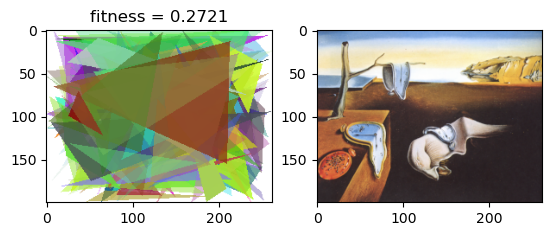

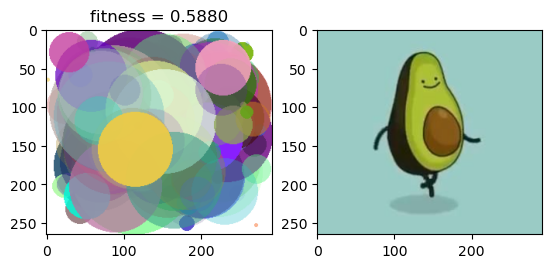

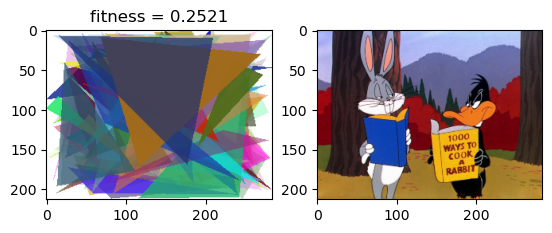

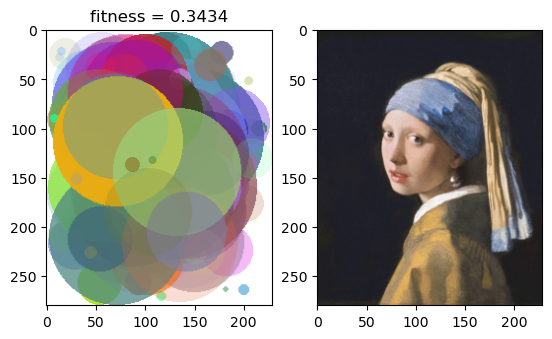

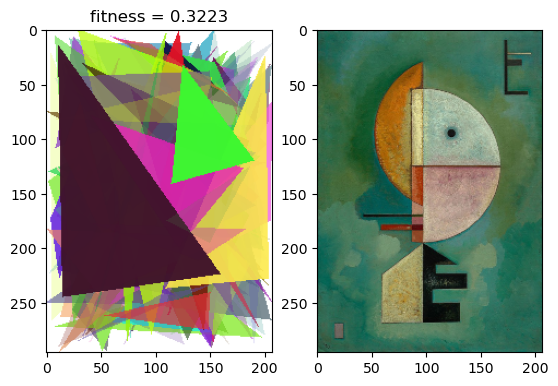

In [274]:
test_reconstruction_GA(test_images)

### Meta-optimization of GA for image reconstruction - using GA

#### ParamsIndividual class implementation  
ParamsIndividual is represented as a list of meta-parameters used for GA for image reconstruction.  
Initialization is random.  
Fitness is calculated by executing GA for image reconstruction with meta-parameters defined by ParamsIndividual code.

In [252]:
class Params(Enum):
    NUM_FIGS = 0
    NUM_GENS = 1
    POP_SIZE = 2
    ELITISM = 3
    MUTATION_PROB = 4
    CROSSOVER = 5
    SELECTION = 6

In [253]:
class ParamsIndividual:

    # Elitism is either used or not, and if used, elitism size is a percentage of population size.
    # For uniform crossover, param is None; For k-point crossover, param k takes a value from 1 up to number of figures 
    # (which defines code length); And for mix crossover, alpha param is in [0,1].
    # Tournament size is calculated based on population size and no param is needed for roulette selection (except fitnesses).
    
    def __init__(self, original_image, fig_type,
                 num_figs_dom, num_gens_dom, pop_size_dom, mutation_prob_lmt, crossover_dom, selection_dom):
        self.code = self.initialize(num_figs_dom, num_gens_dom, pop_size_dom, mutation_prob_lmt, crossover_dom, selection_dom)
        self.best_individual = None
        self.fitness = self.calc_fitness(fig_type, original_image)

    def initialize(self, num_figs_dom, num_gens_dom, pop_size_dom, mutation_prob_lmt, crossover_dom, selection_dom):
        code = [None for _ in range(len(Params))]

        num_figs = random.choice(list(num_figs_dom))
        code[Params.NUM_FIGS.value] = num_figs
        code[Params.NUM_GENS.value] = random.choice(list(num_gens_dom))
        pop_size = random.choice(list(pop_size_dom))
        code[Params.POP_SIZE.value] = pop_size
        
        use_elitism = random.choice([True, False])
        elitism_size = 0
        if use_elitism:
            # elitistic population size is between 5% and 25% of population size
            elitism_size = random.randrange(math.ceil(0.05 * pop_size), math.ceil(0.25 * pop_size))
        
        code[Params.ELITISM.value] = (use_elitism, elitism_size)
        code[Params.MUTATION_PROB.value] = random.uniform(0.01, mutation_prob_lmt)
        
        cross = random.choice(list(crossover_dom))
        cross_param = None
        if cross == CrossType.KPOINT:
            cross_param = random.randrange(1, math.ceil(0.3 * num_figs))
        elif cross == CrossType.MIX:
            cross_param = random.uniform(0, 1)
        code[Params.CROSSOVER.value] = (cross, cross_param)

        selection = random.choice(list(selection_dom))
        selection_param = None
        if selection == SelectType.TOURNAMENT:
            # If tournament size = 1 -> selection is random.
            # If tournament size = population size -> the best individual will be picked in each generation.
            # Here, tournament size is between 10% and 50% of population size
            selection_param = random.randrange(math.ceil(0.1 * pop_size), math.ceil(0.5 * pop_size))
        code[Params.SELECTION.value] = (selection, selection_param)
        
        return code

    def calc_fitness(self, fig_type, original_image):
        # Fitness is equal to the fitness of the best individual found by GA for image reconstruction.

        best = ga_reconstruction(
            image=original_image,
            figure_type=fig_type,
            num_figures=self.code[Params.NUM_FIGS.value],
            num_generations=self.code[Params.NUM_GENS.value],
            population_size=self.code[Params.POP_SIZE.value],
            use_elitism=self.code[Params.ELITISM.value][0], elitism_size = self.code[Params.ELITISM.value][1],
            mutation_prob=self.code[Params.MUTATION_PROB.value],
            crossover_type=self.code[Params.CROSSOVER.value][0], crossover_param=self.code[Params.CROSSOVER.value][1],
            selection_type=self.code[Params.SELECTION.value][0], selection_param=self.code[Params.SELECTION.value][1]
        )

        self.best_individual = best
        
        fitness = best.fitness
        return fitness

#### Crossover method - uniform crossover

In [254]:
def params_uniform_crossover(parent1, parent2, child1, child2, prob=0.5):
    for i in range(len(parent1.code)):
        if random.random() < prob:
            child1.code[i] = parent1.code[i]
            child2.code[i] = parent2.code[i]
        else:
            child1.code[i] = parent2.code[i]
            child2.code[i] = parent1.code[i]

    # some params are mutually dependent, crossover may create infeasible solutions
    feasible = [True, True]
    for i, child in enumerate([child1, child2]):
        use_elitism, elitism_size = child.code[Params.ELITISM.value]
        cross_type, cross_param = child.code[Params.CROSSOVER.value]
        select_type, select_param = child.code[Params.SELECTION.value]
        pop_size = child.code[Params.POP_SIZE.value]
        num_figs = child.code[Params.NUM_FIGS.value]

        if (use_elitism and elitism_size not in range(math.ceil(0.05 * pop_size), math.ceil(0.25 * pop_size))) or (cross_type == CrossType.KPOINT and cross_param not in range(1, math.ceil(0.3 * num_figs))) or (select_type == SelectType.TOURNAMENT and select_param not in range(math.ceil(0.1 * pop_size), math.ceil(0.5 * pop_size))):
            feasible[i] = False

    if not feasible[0]:
        child1.code[:] = parent1.code[:]
    if not feasible[1]:
        child2.code[:] = parent2.code[:]

#### Mutation  
Each gene mutates with a given probability.  
Since each gene represents a different meta-parameter, mutation is defined differently for each gene.

In [255]:
def params_mutation(individual, num_figs_dom, num_gens_dom, pop_size_dom, mutation_prob_lmt,
                    crossover_dom, selection_dom, mutation_prob=0.1):
    for i in range(len(individual.code)):
        if random.random() < mutation_prob:
            # each gene allele has a different domain
            if i == Params.NUM_FIGS.value:
                rnd = random.choice(list(set(range(-5, 5)).difference({0})))
                new_val = individual.code[i] + rnd
                if new_val in num_figs_dom:
                    individual.code[i] = new_val
            
            elif i == Params.NUM_GENS.value:
                rnd = random.choice(list(set(range(-2, 2)).difference({0})))
                new_val = individual.code[i] + rnd * GENS_STEP
                if new_val in num_gens_dom:
                    individual.code[i] = new_val
                
            elif i == Params.POP_SIZE.value:
                rnd = random.choice(list(set(range(-20, 21, 2)).difference({0})))
                new_val = individual.code[i] + rnd
                if new_val in pop_size_dom:
                    individual.code[i] = new_val

            elif i == Params.ELITISM.value:
                use_elitism = not individual.code[i][0]
                elitism_size = 0
                if use_elitism:
                    pop_size = individual.code[Params.POP_SIZE.value]
                    elitism_size = random.randrange(math.ceil(0.05 * pop_size), math.ceil(0.25 * pop_size))
                individual.code[i] = (use_elitism, elitism_size)

            elif i == Params.MUTATION_PROB.value:
                rnd = random.uniform(-0.05, 0.05)
                new_val = individual.code[i] + rnd
                if new_val >= 0.01 and new_val <= mutation_prob_lmt: 
                    individual.code[i] = new_val

            elif i == Params.CROSSOVER.value:
                rnd_cross_type = random.choice(list(set(CrossType).difference({individual.code[i][0]})))
                cross_param = None
                if rnd_cross_type == CrossType.KPOINT:
                    cross_param = random.randrange(1, math.ceil(0.3 * individual.code[Params.NUM_FIGS.value]))
                elif rnd_cross_type == CrossType.MIX:
                    cross_param = random.uniform(0, 1)
                individual.code[i] = (rnd_cross_type, cross_param)

            elif i == Params.SELECTION.value:
                rnd_select_type = random.choice(list(set(SelectType).difference({individual.code[i][0]})))
                selection_param = None
                if rnd_select_type == SelectType.TOURNAMENT:
                    pop_size = individual.code[Params.POP_SIZE.value]
                    selection_param = random.randrange(math.ceil(0.1 * pop_size), math.ceil(0.5 * pop_size))
                individual.code[i] = (rnd_select_type, selection_param)

#### Meta-optimization of image reconstruction  
Returns the best parameter values for GA reconstruction (ParamsIndividual code) and best reconstruction of an image ever found for a given image and figure type.

In [256]:
def ga_opt_reconstruction(
    num_generations,
    population_size,
    use_elitism,
    elitism_size,
    tournament_size,
    mutation_prob,
    image,
    figure_type,
    num_figs_dom,
    num_gens_dom,
    pop_size_dom,
    mutation_prob_lmt,
    crossover_dom,
    selection_dom
):
    if use_elitism and (population_size - elitism_size) % 2 == 1:
        elitism_size += 1

    print('Initializing population...')
    population = [ParamsIndividual(image, figure_type, num_figs_dom, num_gens_dom, pop_size_dom,
                                   mutation_prob_lmt, crossover_dom, selection_dom) for _ in range(population_size)]
    new_population = [ParamsIndividual(image, figure_type, num_figs_dom, num_gens_dom, pop_size_dom,
                                   mutation_prob_lmt, crossover_dom, selection_dom) for _ in range(population_size)]

    fitnesses = []
    legends = []
    
    for i in tqdm(range(num_generations), f'Optimizing...'):

        if use_elitism:
            population.sort(key=lambda x: x.fitness, reverse=True)
            new_population[:elitism_size] = population[:elitism_size]

        for i in range(elitism_size, population_size, 2):

            parent1_idx = tournament_selection(population, tournament_size=tournament_size, forbidden=None)
            parent2_idx = tournament_selection(population, tournament_size=tournament_size, forbidden=parent1_idx)

            params_uniform_crossover(
                population[parent1_idx], population[parent2_idx],
                new_population[i], new_population[i+1]
            )
            
            params_mutation(new_population[i], num_figs_dom, num_gens_dom, pop_size_dom, mutation_prob_lmt,
                            crossover_dom, selection_dom, mutation_prob)
            params_mutation(new_population[i+1], num_figs_dom, num_gens_dom, pop_size_dom, mutation_prob_lmt,
                            crossover_dom, selection_dom, mutation_prob)

            new_population[i].fitness = new_population[i].calc_fitness(figure_type, image)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(figure_type, image)

        population = deepcopy(new_population)

        best_in_pop = max(population, key=lambda x: x.fitness)
        fitnesses.append(best_in_pop.fitness)
        legends.append(best_in_pop)

    plt.title("Best individual fitness per generation")
    plt.plot([i+1 for i in range(num_generations)], fitnesses)
    
    return max(legends, key=lambda x: x.fitness)

#### Testing meta-opt. GA  

In [275]:
NUM_FIGS_LMT = 200
GENS_STEP = 10
NUM_GENS_LMT = 200
POP_STEP = 2
POP_SIZE_LMT = 200
NUM_FIGS_DOM = range(50, NUM_FIGS_LMT)
NUM_GENS_DOM = range(50, NUM_GENS_LMT, GENS_STEP)
POP_SIZE_DOM = range(10, POP_SIZE_LMT, POP_STEP)
MUTATION_PROB_LMT = 0.2
CROSSOVER_DOM = set(list(CrossType))
SELECTION_DOM = set(list(SelectType))

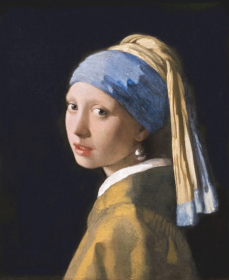

In [267]:
rnd_test_image = random.choice(test_images)
rnd_test_image

In [271]:
rnd_figure_type = random.choice(list(FigType))
rnd_figure_type

<FigType.CIRCLE: 1>

Initializing population...


Optimizing...: 100%|██████████████████████████████████████████████| 4/4 [2:14:43<00:00, 2020.87s/it]


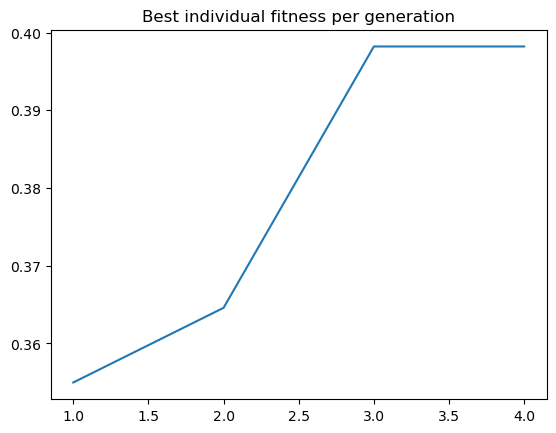

In [277]:
the_best = ga_opt_reconstruction(
    num_generations = 4,
    population_size = 6,
    use_elitism = True,
    elitism_size = 2,
    tournament_size = 2,
    mutation_prob = 0.1,
    image = rnd_test_image,
    figure_type = rnd_figure_type,
    num_figs_dom = NUM_FIGS_DOM,
    num_gens_dom = NUM_GENS_DOM,
    pop_size_dom = POP_SIZE_DOM,
    mutation_prob_lmt = MUTATION_PROB_LMT,
    crossover_dom = CROSSOVER_DOM,
    selection_dom = SELECTION_DOM
)

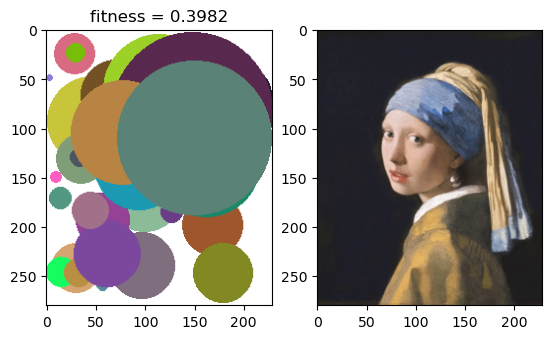

In [278]:
img = Image.new("RGB", rnd_test_image.size, 'white')
reconstruction = draw_individual(the_best.best_individual, img, rnd_figure_type)
fig, axarr = plt.subplots(nrows=1, ncols=2)
axarr[0].set_title(f'fitness = {the_best.fitness:.4f}')
axarr[0].imshow(reconstruction)
axarr[1].imshow(rnd_test_image)
plt.show()

In [279]:
def print_params(result: ParamsIndividual):
    print(f"Best fitness :: {result.fitness}")
    print(f"Number of figures :: {result.code[Params.NUM_FIGS.value]}")
    print(f"Number of generations :: {result.code[Params.NUM_GENS.value]}")
    print(f"Population size :: {result.code[Params.POP_SIZE.value]}")
    if result.code[Params.ELITISM.value][0]:
        print(f"Elitistic population size :: {result.code[Params.ELITISM.value][1]}")
    else:
        print(f"Elitism not used")
    print(f"Mutation probability :: {result.code[Params.MUTATION_PROB.value]}")
    print(f"Crossover method :: {result.code[Params.CROSSOVER.value][0].name} with crossover parameter :: {result.code[Params.CROSSOVER.value][1]}")
    print(f"Selection method :: {result.code[Params.SELECTION.value][0].name} with selection parameter :: {result.code[Params.SELECTION.value][1]}")

In [280]:
print_params(the_best)

Best fitness :: 0.3982064604050329
Number of figures :: 58
Number of generations :: 100
Population size :: 176
Elitistic population size :: 40
Mutation probability :: 0.14815198952856223
Crossover method :: MIX with crossover parameter :: 0.5903719608505199
Selection method :: TOURNAMENT with selection parameter :: 39


#### Meta-opt. GA vs. random value assignment  
Estimating the quality of developed meta-opt. GA by comparing its results with the results of GA for image reconstruction with randomly assigned values for meta-parameters, for each test image and each figure type.  
Expectation: Reconstruction that meta-opt. GA finds by optimizing meta-parameters is better than the one found with reconstruction GA with fixed randomly assigned values to meta-parameters.

In [283]:
def test_quality(tests, figure_types):

    random_fitnesses = []
    meta_fitnesses = []
    test_instances = []
    
    for test in tqdm(tests, "Testing..."):
        for figure_type in figure_types:

            # assigning random values - essentially the same as ParamsIndividual initialization
            num_figs = random.choice(list(NUM_FIGS_DOM))
            num_gens = random.choice(list(NUM_GENS_DOM))
            pop_size = random.choice(list(POP_SIZE_DOM))
        
            use_elitism = random.choice([True, False])
            elitism_size = 0
            if use_elitism:
                elitism_size = random.randrange(math.ceil(0.05 * pop_size), math.ceil(0.25 * pop_size))
            mutation_prob = random.uniform(0.01, MUTATION_PROB_LMT)
        
            cross = random.choice(list(CROSSOVER_DOM))
            cross_param = None
            if cross == CrossType.KPOINT:
                cross_param = random.randrange(1, math.ceil(0.3 * num_figs))
            elif cross == CrossType.MIX:
                cross_param = random.uniform(0, 1)

            selection = random.choice(list(SELECTION_DOM))
            selection_param = None
            if selection == SelectType.TOURNAMENT:
                selection_param = random.randrange(math.ceil(0.1 * pop_size), math.ceil(0.5 * pop_size))
            
            random_best = ga_reconstruction(
                image = test,
                figure_type = figure_type,
                num_figures = num_figs,
                num_generations = num_gens,
                population_size = pop_size,
                use_elitism = use_elitism, elitism_size = elitism_size,
                mutation_prob = mutation_prob,
                crossover_type = cross, crossover_param = cross_param,
                selection_type = selection, selection_param = selection_param
            )
            
            meta_best = ga_opt_reconstruction(
                num_generations = 4,
                population_size = 4,
                use_elitism = True,
                elitism_size = 2,
                tournament_size = 2,
                mutation_prob = 0.1,
                image = test,
                figure_type = figure_type,
                num_figs_dom = NUM_FIGS_DOM,
                num_gens_dom = NUM_GENS_DOM,
                pop_size_dom = POP_SIZE_DOM,
                mutation_prob_lmt = MUTATION_PROB_LMT,
                crossover_dom = CROSSOVER_DOM,
                selection_dom = SELECTION_DOM
            )

            meta_fitnesses.append(meta_best.fitness)
            random_fitnesses.append(random_best.fitness)
            test_instances.append((test, figure_type))

    return random_fitnesses, meta_fitnesses, test_instances
      

Testing...:   0%|                                                             | 0/5 [00:00<?, ?it/s]

Initializing population...



Optimizing...: 100%|█████████████████████████████████████████████████| 4/4 [37:32<00:00, 563.14s/it]


Initializing population...



Optimizing...: 100%|█████████████████████████████████████████████████| 4/4 [40:50<00:00, 612.50s/it]


Initializing population...



Testing...:  20%|█████████                                    | 1/5 [6:15:08<25:00:34, 22508.68s/it]

Initializing population...



Optimizing...: 100%|███████████████████████████████████████████████| 4/4 [1:04:50<00:00, 972.62s/it]


Initializing population...



Optimizing...: 100%|█████████████████████████████████████████████████| 4/4 [51:58<00:00, 779.65s/it]


Initializing population...



Testing...:  40%|█████████████████▌                          | 2/5 [12:46:43<19:14:26, 23088.71s/it]

Initializing population...



Optimizing...: 100%|██████████████████████████████████████████████| 4/4 [1:44:18<00:00, 1564.51s/it]


Initializing population...



Optimizing...: 100%|███████████████████████████████████████████████| 4/4 [1:03:36<00:00, 954.11s/it]


Initializing population...



Testing...:  60%|██████████████████████████▍                 | 3/5 [19:05:01<12:43:40, 22910.20s/it]

Initializing population...



Optimizing...: 100%|██████████████████████████████████████████████| 4/4 [4:47:26<00:00, 4311.59s/it]


Initializing population...



Optimizing...: 100%|██████████████████████████████████████████████| 4/4 [1:20:17<00:00, 1204.41s/it]


Initializing population...



Testing...:  80%|████████████████████████████████████         | 4/5 [30:02:46<8:10:45, 29445.89s/it]

Initializing population...



Optimizing...: 100%|█████████████████████████████████████████████████| 4/4 [43:20<00:00, 650.23s/it]


Initializing population...



Optimizing...: 100%|██████████████████████████████████████████████| 4/4 [2:51:39<00:00, 2574.99s/it]


Initializing population...



Testing...: 100%|███████████████████████████████████████████████| 5/5 [38:22:50<00:00, 27634.12s/it]


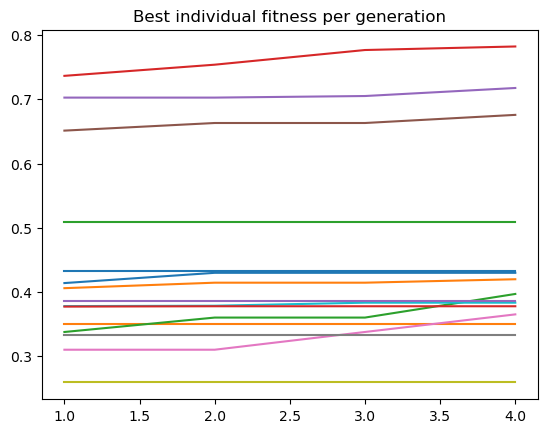

In [285]:
rnd_assign_fits, meta_opt_fits, tests = test_quality(tests=test_images, figure_types=list(FigType))

In [286]:
rnd_assign_fits

[0.34306328368836575,
 0.29190337649612225,
 0.2803722009113138,
 0.6140985993985261,
 0.5319020651130547,
 0.5653622605266708,
 0.30960441908835384,
 0.31457370603131307,
 0.2517676813432736,
 0.2997631505949965,
 0.3277804938142449,
 0.26038462437532645,
 0.3938381226909944,
 0.3823794088229975,
 0.3330230682296625]

In [287]:
meta_opt_fits

[0.42972516421016077,
 0.3500477416397758,
 0.396791453517881,
 0.7823321477645476,
 0.7176680200351496,
 0.6757857430970243,
 0.36496966413160586,
 0.33261795335194194,
 0.2588872876619743,
 0.3831994939158374,
 0.43231863832343825,
 0.4197114255160761,
 0.5096171010541766,
 0.3776333194402424,
 0.3859317298962746]

In [288]:
tests

[(<PIL.Image.Image image mode=RGB size=262x200>, <FigType.SQUARE: 0>),
 (<PIL.Image.Image image mode=RGB size=262x200>, <FigType.CIRCLE: 1>),
 (<PIL.Image.Image image mode=RGB size=262x200>, <FigType.TRIANGLE: 2>),
 (<PIL.Image.Image image mode=RGB size=292x265>, <FigType.SQUARE: 0>),
 (<PIL.Image.Image image mode=RGB size=292x265>, <FigType.CIRCLE: 1>),
 (<PIL.Image.Image image mode=RGB size=292x265>, <FigType.TRIANGLE: 2>),
 (<PIL.Image.Image image mode=RGB size=284x213>, <FigType.SQUARE: 0>),
 (<PIL.Image.Image image mode=RGB size=284x213>, <FigType.CIRCLE: 1>),
 (<PIL.Image.Image image mode=RGB size=284x213>, <FigType.TRIANGLE: 2>),
 (<PIL.Image.Image image mode=RGB size=229x280>, <FigType.SQUARE: 0>),
 (<PIL.Image.Image image mode=RGB size=229x280>, <FigType.CIRCLE: 1>),
 (<PIL.Image.Image image mode=RGB size=229x280>, <FigType.TRIANGLE: 2>),
 (<PIL.Image.Image image mode=RGB size=207x296>, <FigType.SQUARE: 0>),
 (<PIL.Image.Image image mode=RGB size=207x296>, <FigType.CIRCLE: 1>)

In [331]:
def compare_results(random_fitnesses, meta_fitnesses, test_instances):
    fig = plt.figure(figsize=(13,5))
    plt.title("Meta-opt. GA compared to random value assignment")
    plt.xlabel("test instance")
    plt.ylabel("fitness achieved")
    x_axis = [f"{i+1}" for i, _ in enumerate(test_instances)]
    plt.plot(x_axis, random_fitnesses, 'o-', label="Random assignment")
    plt.plot(x_axis, meta_fitnesses, 'x-', markeredgewidth=2, color='orange', label="Meta-opt. GA")
    plt.legend()
    plt.show()
    
    # where meta-opt. GA did better
    better = sum([meta_fitnesses[i] > random_fitnesses[i] for i in range(len(test_instances))])
    print(f"Number of test instances for which meta-opt. GA did better :: {better}/{len(test_instances)}")

    # where meta-opt. ga did worse
    print("Where meta-opt. GA did worse:")
    worse = [(meta_fitnesses[i], random_fitnesses[i], i) for i in range(len(test_instances)) if meta_fitnesses[i] <= random_fitnesses[i]]
    for mf, rf, ti in worse:
        print(f"Test instance {ti+1}:\nmeta-opt. GA achieved \t:: {mf}\nrandom assign. achieved :: {rf}")
        _, axarr = plt.subplots(nrows=1, ncols=1)
        axarr.set_title(f'figure type :: {test_instances[ti][1].name}')
        axarr.imshow(test_instances[ti][0])

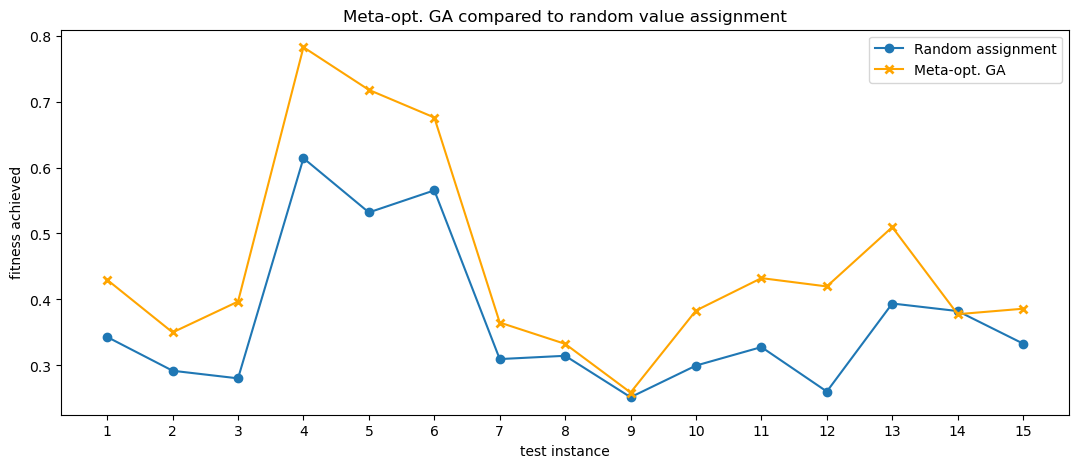

Number of test instances for which meta-opt. GA did better :: 14/15
Where meta-opt. GA did worse:
Test instance 14:
meta-opt. GA achieved 	:: 0.3776333194402424
random assign. achieved :: 0.3823794088229975


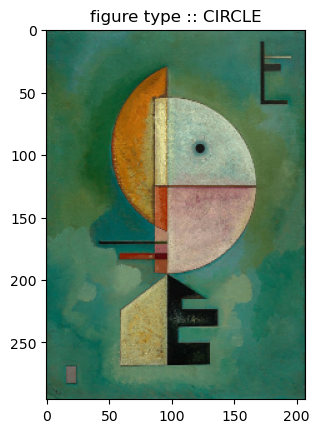

In [332]:
compare_results(rnd_assign_fits, meta_opt_fits, tests)